# INF 264 - Project 2: Digit recognizer

## Introduction

In this project we will be using different classifiers to classify handwritten digits from the MNIST handwritten digits database. We will be evaluating the different classifiers by testing how well they perform on unseen data and selecting the best model based on the performance on validation data. Finally we will see how well the best model generalizes by seeing how well it performs on testing data.

In [1]:
#imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier

## Helper funcitions

In [2]:
#Function to plot the distribution of labels and printing the number of each label
def plot_distribution(labels):
    #Plots the histogram
    plt.hist(labels, bins=np.arange(12)-0.5, color='blue', edgecolor='black')
    plt.xticks(np.arange(0, 11, 1))
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.title('Distribution of Labels')
    plt.show()

    #List to store the label counts
    label_counts = []

    #Calculate the label count for each label
    for i in range(11):
        label_count = np.sum(labels == i)
        label_counts.append(label_count)

    #Print the label counts as well as the percentage of the total
    for i in range(11):
        print("Label {}: {} ({:.2f}%)".format(i, label_counts[i], label_counts[i]/len(labels)*100))


#Function to plot a confusion matrix
def plot_confusion_matrix(y_val, y_pred, title):
    cm = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, square=True)
    plt.title(title)
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

#Pipleline to train and test the model, then store the results
def train_and_test(model, model_name, X_train, y_train, X_val, y_val):
    #Reshape the data to be 2D
    X_train = X_train.reshape(X_train.shape[0], -1)
    X_val = X_val.reshape(X_val.shape[0], -1)

    #Train the model
    model.fit(X_train, y_train)

    #Make predictions on the validation set
    y_pred = model.predict(X_val)

    #Calculate accuracy
    accuracy = accuracy_score(y_val, y_pred)

    #Store the results
    store_results(model_name, model, y_pred, accuracy)

## Loading in and exploring the data

In this section we will load in the datas and explore it a bit. We want to see how the data is structured, what the value ranges are, the label distribution as well as if there are any null values or duplicate values in the data.

In [3]:
#read in MNIST-images.npy and MNIST-labels.npy
images = np.load('MNIST-images.npy')
labels = np.load('MNIST-labels.npy')

#First lets print the shape of the images and labels
print("Shape of images: ", images.shape)
print("Shape of labels: ", labels.shape)

Shape of images:  (85273, 24, 24, 1)
Shape of labels:  (85273,)


In [4]:
###############################################################
#TEMPORARY REMOVE DATAPOINTS FOR TESTING

# images = images[0:1000]
# labels = labels[0:1000]

We can see that there are a total of 85273 images and labels where each image is a 24x24 array. Next let's look at the value range

In [5]:
#Lets see what the range of values are
print("Range of values in images: ", np.min(images), "to", np.max(images))
print("Range of values in labels: ", np.min(labels), "to", np.max(labels))

Range of values in images:  0 to 255
Range of values in labels:  0 to 10


We can see that the values range from 0 to 10 where 10 means "not a number". Each image has a value from 0 to 255. These are greyscalevalues where 0 means white and 255 means black.

In [6]:
#Let's see if there are any null values in the dataset
print("Dataset contains null values: ", np.any(np.isnan(images)))

Dataset contains null values:  False


It looks like our dataset is complete, which means we don't have to account for null values by imputing values.

In [7]:
#See how many duplicate images there are
print("Number of duplicate images: ", len(images) - len(np.unique(images, axis=0)))

Number of duplicate images:  0


It also seems that all the images are unique. Next we will have a look at the fist few images. 

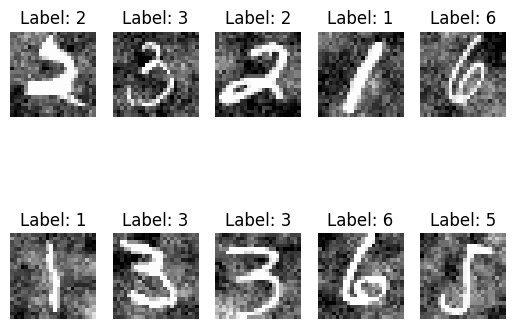

In [8]:
#Plot the first 10 images
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(images[i], cmap='gray')
    plt.title('Label: {}'.format(labels[i]))
    plt.axis('off')

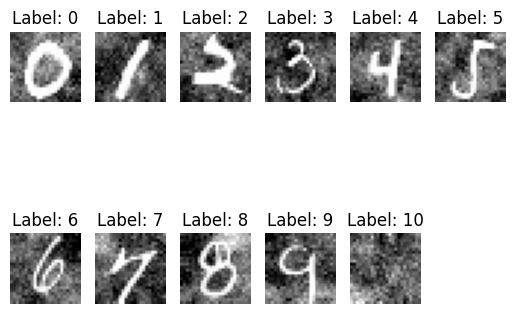

In [9]:
#Next lets look at all the different numbers
for i in range(11):
    plt.subplot(2, 6, i+1)
    plt.imshow(images[labels == i][0], cmap='gray')
    plt.title('Label: {}'.format(labels[labels == i][0]))
    plt.axis('off')

It is worth noting that there is quite a bit of noice in the background. Let's try to reduce this noise by setting all pixels less than a threshold to 0 and all pixels above the threshold to 255.

In [10]:
# images = images/255

# #plot the first 10 images
# for i in range(10):
#     plt.subplot(2, 5, i+1)
#     plt.imshow(images[i], cmap='gray')
#     plt.title('Label: {}'.format(labels[i]))
#     plt.axis('off')

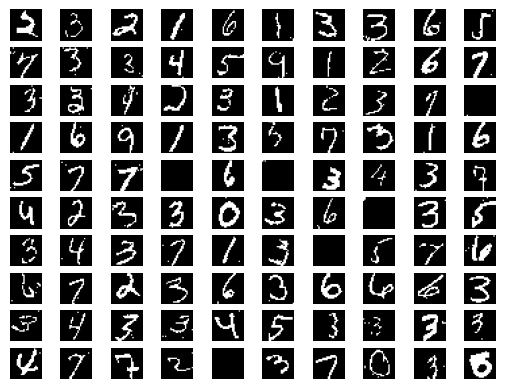

In [11]:
#Remove background noise from the images by setting all values less than 200 to 0 (black) and all values greater than 200 to 255 (white)
threshold = 200
images[images < threshold] = 0
images[images >= threshold] = 1

#Plot the first 100 images
for i in range(100):
    plt.subplot(10, 10, i+1)
    plt.imshow(images[i], cmap='gray')
    plt.axis('off')

We experimented with different values for the threshold and inspected the numbers for each one. In the end we used 200 as a thershold as this seemed to work well.

Also note that we set the values below the threshold to 0 and above the threshold to 1. This has the same effect.

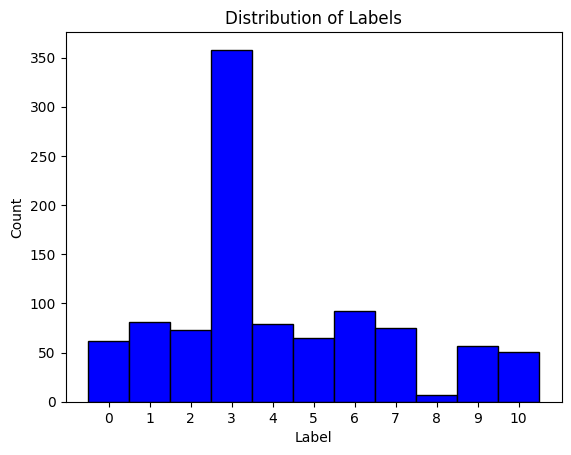

Label 0: 62 (6.20%)
Label 1: 81 (8.10%)
Label 2: 73 (7.30%)
Label 3: 358 (35.80%)
Label 4: 79 (7.90%)
Label 5: 65 (6.50%)
Label 6: 92 (9.20%)
Label 7: 75 (7.50%)
Label 8: 7 (0.70%)
Label 9: 57 (5.70%)
Label 10: 51 (5.10%)


In [12]:
#Next lets look at the distribution of labels in the dataset
plot_distribution(labels)

We can see that there is an imbalance in the dataset. There are way more images of three's than the rest of the numbers. Also we can see that there are very few eight's in the dataset. This imbaleance is something we need to take into account when choosing which metric to use for evaluating model performance. For example is accuracy score generally a poor metric for evaluating model performance on imbalanced data because it means our models could favor predicting the majority labels. In the extreme case if the data is really unbalanced we can simply predict the majority label every time and get a pretty good accuracy score. We could choose another metric like recall, precision or a combination like the F1 score, but this is generally used when the positive class is more important to predict than the negative class. In our case it is equally important to classify all the labels correctly so I will instead try to deal with the imbalance in another way.

One method we can use to deal with the issue of the imbalance is to use resampling techniques. For example we could randomly remove about 24,000 three's to try and balance the data. This is called under-sampling. One disadvantage of this is that we lose a lot of our training data which may reduce the performance of a selected model. Also the small sample of three's selected may not represent the entire population of three's.

Similarily we can use over-sampling for the eight's by randomly duplicating or generate new eight's by using synthetic minority oversampling technique (SMOTE). The problem with this is that this can increase the chance of overfitting.

Later in the report after we have split the data into training, validation and testing we will try out these techniques on the training data.


Another thing we need to take into consideration is which classifiers to use on imbalanced datasets. Decision trees are known to perform well on imbalanced data, in particular ensembles like Random Forest Classifier. Therefore one of the classifiers we will use is the Random Forest Classifier.

## Splitting the data

In [13]:
#Splitting the data into training, validation and testing sets
X_train, X_val_test, y_train, y_val_test = train_test_split(images, labels, test_size=0.7, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

Here we have used 70% of the data as training data, 15% for validation and 15% for testing. Lets have a quick look at the distribution of the training data.

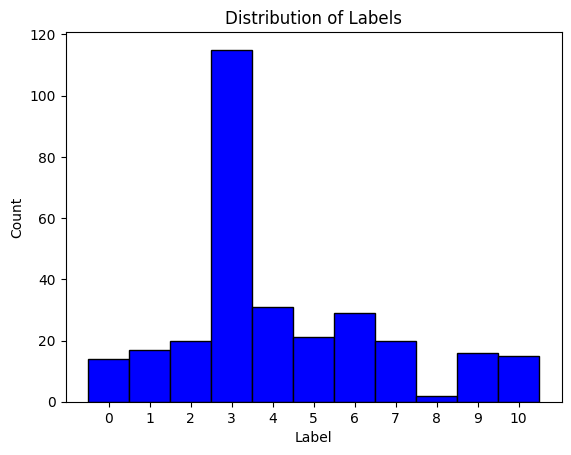

Label 0: 14 (4.67%)
Label 1: 17 (5.67%)
Label 2: 20 (6.67%)
Label 3: 115 (38.33%)
Label 4: 31 (10.33%)
Label 5: 21 (7.00%)
Label 6: 29 (9.67%)
Label 7: 20 (6.67%)
Label 8: 2 (0.67%)
Label 9: 16 (5.33%)
Label 10: 15 (5.00%)


In [14]:
plot_distribution(y_train)

we can see that the training data is still imbalanced with very many three's and few eight's. So let's try to fix this now.

## Undersampling the three's
In this section we will select a random subset of the three's to use as our training data and we will discard the rest. As discussed earlier this means we will lose a lot of information, but hopefully the performance will be better.

In [15]:
#Create a list of indexes where the label is 3 in the training set 
index_list = np.where(y_train == 3)[0]

#Set seed for reproducibility
np.random.seed(42)

#We will remove 70% of the images with label 3 from the training set
remove_n = int(0.7 * len(index_list))

#Select  random indexes
random_indexes = np.random.choice(index_list, remove_n, replace=False)

#Remove the random indexes from the index list
X_train_undersample = np.delete(X_train, random_indexes, axis=0)
y_train_undersample = np.delete(y_train, random_indexes, axis=0)

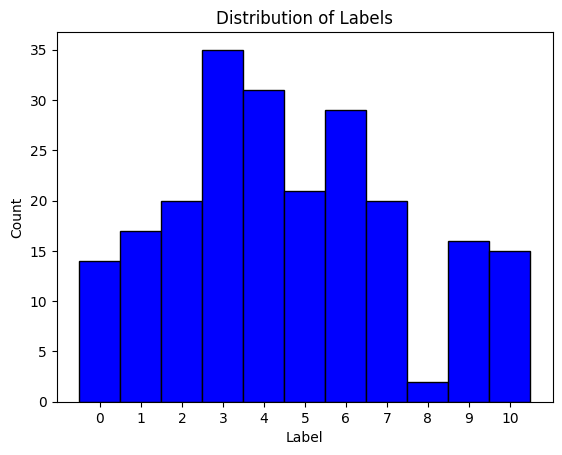

Label 0: 14 (6.36%)
Label 1: 17 (7.73%)
Label 2: 20 (9.09%)
Label 3: 35 (15.91%)
Label 4: 31 (14.09%)
Label 5: 21 (9.55%)
Label 6: 29 (13.18%)
Label 7: 20 (9.09%)
Label 8: 2 (0.91%)
Label 9: 16 (7.27%)
Label 10: 15 (6.82%)


In [16]:
#Lets see what the distribution of labels is now
plot_distribution(y_train_undersample)

## Oversampling

In [17]:
#Oversample the rows with label 8
strategy = {8: 2000}
oversample = SMOTE(random_state=42, sampling_strategy=strategy)

#Flatten the data
X_train_undersample_flat = X_train_undersample.reshape(X_train_undersample.shape[0], -1)

X_train_resample, y_train_resample = oversample.fit_resample(X_train_undersample_flat, y_train_undersample)

plot_distribution(y_train_resample)

/home/maloha/.local/lib/python3.8/site-packages/imblearn/utils/_validation.py:299: UserWarning: After over-sampling, the number of samples (2000) in class 8 will be larger than the number of samples in the majority class (class #3 -> 35)
  warnings.warn(


ValueError: Expected n_neighbors <= n_samples,  but n_samples = 2, n_neighbors = 6

Lets now take a look at some of the synthetically generated eight's

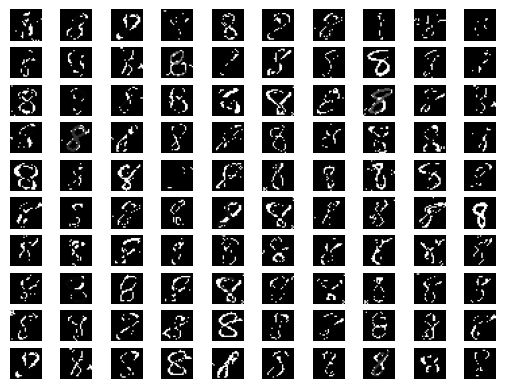

In [ ]:
#Find rows in X_train_resample that have label 8
index_list = np.where(y_train_resample == 8)[0]

#Find rows in X_train that have label 8
index_list_original = np.where(y_train_undersample == 8)[0]

#Find all the indecies in index_list that are not in index_list_original
index_list = np.setdiff1d(index_list, index_list_original)

# Plot the first 100 images from index list
for i in range(100):
    plt.subplot(10, 10, i+1)
    plt.imshow(X_train_resample[index_list[i]].reshape(24, 24), cmap='gray')
    plt.axis('off')

We can see that most of the eight's does not look good. We can do this in another way instead.
I nice proprety about eigh's is that they are both horizontally and vertically symmetric. This means we can get more samples by flipping the eighs horizontally/vertically/both.

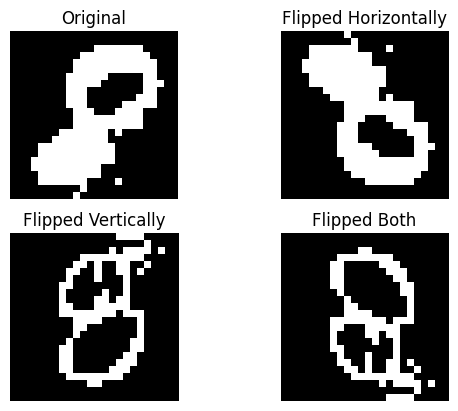

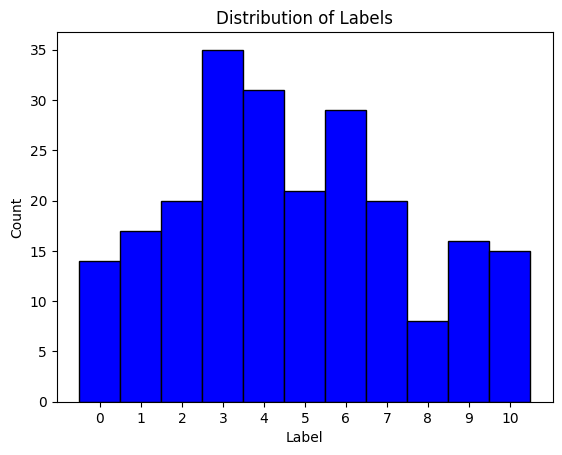

Label 0: 14 (6.19%)
Label 1: 17 (7.52%)
Label 2: 20 (8.85%)
Label 3: 35 (15.49%)
Label 4: 31 (13.72%)
Label 5: 21 (9.29%)
Label 6: 29 (12.83%)
Label 7: 20 (8.85%)
Label 8: 8 (3.54%)
Label 9: 16 (7.08%)
Label 10: 15 (6.64%)


In [ ]:
#Get all eight's from X_train_undersample and y_train_undersample
X_train_undersample_8 = X_train_undersample[y_train_undersample == 8]
y_train_undersample_8 = y_train_undersample[y_train_undersample == 8]

#Flip the images horizontally
X_train_undersample_8_flipped_horizontally = np.fliplr(X_train_undersample_8)

#Flip the images vertically
X_train_undersample_8_flipped_vertically = np.flipud(X_train_undersample_8)

#Flip the images horizontally and vertically
X_train_undersample_8_flipped_both = np.flipud(X_train_undersample_8_flipped_horizontally)


#Plot the first first image from X_train_undersample_8 and X_train_undersample_8_flipped_horizontally and X_train_undersample_8_flipped_vertically and X_train_undersample_8_flipped_both
plt.subplot(2, 2, 1)
plt.imshow(X_train_undersample_8[0], cmap='gray')
plt.title('Original')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(X_train_undersample_8_flipped_horizontally[0], cmap='gray')
plt.title('Flipped Horizontally')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(X_train_undersample_8_flipped_vertically[0], cmap='gray')
plt.title('Flipped Vertically')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(X_train_undersample_8_flipped_both[0], cmap='gray')
plt.title('Flipped Both')
plt.axis('off')
plt.show()

#Add the flipped images to the training set
X_train_resample = np.concatenate((X_train_undersample, X_train_undersample_8_flipped_horizontally, X_train_undersample_8_flipped_vertically, X_train_undersample_8_flipped_both), axis=0)

#Add the labels to the training set
y_train_resample = np.concatenate((y_train_undersample, y_train_undersample_8, y_train_undersample_8, y_train_undersample_8), axis=0)

#Lets see what the distribution of labels is now
plot_distribution(y_train_resample)

## Baseline models
In this section we will look at a couple of baseline models wich we will try to beat with a better performing model later.

### Majority class classifier
This classifier always predicts the majority label

In [ ]:
#First lets create a list where we can store the results of each model and lets create a function to store the results

#Trained and evaluated models
trained_and_evaluated_models = [] 

#Function to store the results of a model
def store_results(model_name, model, y_pred, accuracy_score):
    result = {
        'model_name': model_name,
        'model': model,
        'y_pred': y_pred,
        'accuracy_score': accuracy_score
    }
    trained_and_evaluated_models.append(result)

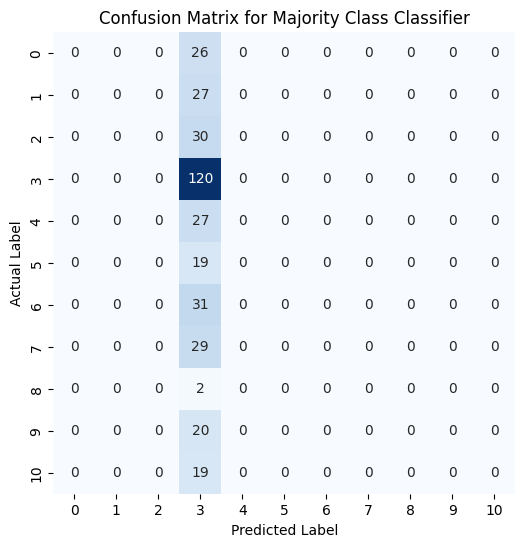

Accuracy:  0.34285714285714286


In [ ]:
#Majority class classifier
y_pred = np.full(y_val.shape, np.argmax(np.bincount(y_train)))

#Plot the confusion matrix for the majority class classifier
plot_confusion_matrix(y_val, y_pred, 'Confusion Matrix for Majority Class Classifier')

#Calculate accuracy
accuracy = accuracy_score(y_val, y_pred)

#Print accuracy
print("Accuracy: ", accuracy)

#Store the results of the majority class classifier
store_results('Majority Class Classifier', None, y_pred, accuracy)


We see that we get an accuracy of 0.3584 which is as expected after looking at the label distribution from earlier. This is not a very good accuracy.

### Random label classifier
This classifier will predic a random label each time

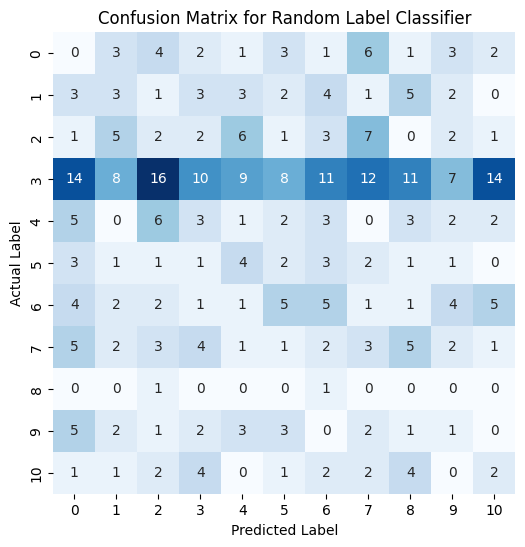

Accuracy:  0.08285714285714285


In [ ]:
#Random label classifier

#Set seed for reproducibility
np.random.seed(42)
y_pred = np.random.randint(0, 11, y_val.shape)

#Plot the confusion matrix for the random label classifier
plot_confusion_matrix(y_val, y_pred, 'Confusion Matrix for Random Label Classifier')

#Calculate accuracy
accuracy = accuracy_score(y_val, y_pred)

#Print the accuracy
print("Accuracy: ", accuracy)

#Store the results of the random label classifier
store_results('Random Label Classifier', None, y_pred, accuracy)

We can see that we got an even worse accuracy of only 0.0914. After looking at theese baseline models we know we should at least try to get a better accuracy than 0.3584.

## Random forest classifier

#TODO: explain why we chose random forest classifier

In [ ]:
%%time
models = []
validation_accuracy = []

#Random Forest Classifier
rfc = RandomForestClassifier(random_state=42)

#Grid search to find the best parameters
rfc_gridSearch = GridSearchCV(rfc, {'n_estimators': [10, 100, 1000], 'criterion': ['gini', 'entropy']}, scoring='accuracy', verbose=4, n_jobs=-1)

#Reshape the data to be 2D
X_train_resample = X_train_resample.reshape(X_train_resample.shape[0], -1)
X_val = X_val.reshape(X_val.shape[0], -1)

#Train the model
rfc_gridSearch.fit(X_train_resample, y_train_resample)

models.append(rfc_gridSearch)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...criterion=gini, n_estimators=10;, score=0.522 total time=   0.0s
[CV 2/5] END ...criterion=gini, n_estimators=10;, score=0.644 total time=   0.0s
[CV 3/5] END ...criterion=gini, n_estimators=10;, score=0.689 total time=   0.0s
[CV 5/5] END ...criterion=gini, n_estimators=10;, score=0.778 total time=   0.0s
[CV 4/5] END ...criterion=gini, n_estimators=10;, score=0.578 total time=   0.0s
[CV 2/5] END ..criterion=gini, n_estimators=100;, score=0.778 total time=   0.1s
[CV 3/5] END ..criterion=gini, n_estimators=100;, score=0.711 total time=   0.1s
[CV 4/5] END ..criterion=gini, n_estimators=100;, score=0.711 total time=   0.1s
[CV 5/5] END ..criterion=gini, n_estimators=100;, score=0.667 total time=   0.1s
[CV 1/5] END ..criterion=gini, n_estimators=100;, score=0.783 total time=   0.1s
[CV 1/5] END criterion=entropy, n_estimators=10;, score=0.652 total time=   0.0s
[CV 2/5] END criterion=entropy, n_estimators=10;,

In [ ]:
#Create table with the results of the grid search
results = pd.DataFrame(rfc_gridSearch.cv_results_)
results = results[['param_n_estimators', 'param_criterion', 'mean_test_score']]
results.columns = ['n_estimators', 'criterion', 'mean_test_score']
results = results.sort_values(by='mean_test_score', ascending=False)
results

,n_estimators,criterion,mean_test_score
2,1000,gini,0.743188
4,100,entropy,0.734106
5,1000,entropy,0.730048
1,100,gini,0.729855
0,10,gini,0.642126
3,10,entropy,0.574879


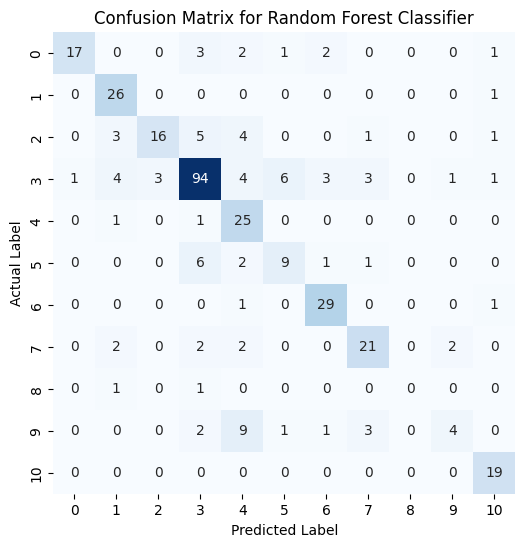

Accuracy:  0.7428571428571429


In [ ]:
#Lets look at the confusion matrix and accuracy for the random forest classifier
y_pred = rfc_gridSearch.predict(X_val)
plot_confusion_matrix(y_val, y_pred, 'Confusion Matrix for Random Forest Classifier')
accuracy = accuracy_score(y_val, y_pred)
validation_accuracy.append(accuracy)
print("Accuracy: ", accuracy)

Already we can see we get a much better accuracy than the baseline model. However we still have a lot of room for improvement. After looking at the confusion matrix we can see that the model predicts a lot of three's. This is also where the model make the most amount of mistakes. We can for example see that in 188 cases the model predicted a 3, but the true label was 8. And it only predicted eight 11 times when the true label was eight. This is does not come as a surprise as we have not yet done anything to deal with the data imbalance. We will do this later. But next let's try to use a suppor vector machine classifier.

## Support vector machine classifier

#TODO: explain why we chose svm

In [ ]:
#Svm classifier
svm = svm.SVC(random_state=42)
svm_gridSearch = GridSearchCV(svm, {'gamma': ['scale', 'auto'], 'kernel': ['linear', 'rbf']}, scoring='accuracy', verbose=4, n_jobs=-1)
svm_gridSearch.fit(X_train_resample, y_train_resample)
models.append(svm_gridSearch)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 5/5] END ........gamma=scale, kernel=linear;, score=0.644 total time=   0.0s
[CV 4/5] END ........gamma=scale, kernel=linear;, score=0.733 total time=   0.0s
[CV 2/5] END ........gamma=scale, kernel=linear;, score=0.756 total time=   0.0s
[CV 3/5] END ........gamma=scale, kernel=linear;, score=0.756 total time=   0.0s[CV 1/5] END ........gamma=scale, kernel=linear;, score=0.739 total time=   0.0s

[CV 1/5] END ...........gamma=scale, kernel=rbf;, score=0.761 total time=   0.0s
[CV 2/5] END ...........gamma=scale, kernel=rbf;, score=0.756 total time=   0.0s
[CV 1/5] END .........gamma=auto, kernel=linear;, score=0.739 total time=   0.0s
[CV 4/5] END ...........gamma=scale, kernel=rbf;, score=0.711 total time=   0.0s
[CV 3/5] END ...........gamma=scale, kernel=rbf;, score=0.756 total time=   0.0s
[CV 2/5] END .........gamma=auto, kernel=linear;, score=0.756 total time=   0.0s
[CV 5/5] END ...........gamma=scale, kernel=rbf;,

In [ ]:
#Create table with the results of the grid search with no index column
results = pd.DataFrame(svm_gridSearch.cv_results_)
results = results[['param_gamma', 'param_kernel', 'mean_test_score']]
results.columns = ['gamma', 'kernel', 'mean_test_score']
results = results.sort_values(by='mean_test_score', ascending=False)
results

,gamma,kernel,mean_test_score
1,scale,rbf,0.729952
0,scale,linear,0.725604
2,auto,linear,0.725604
3,auto,rbf,0.327440


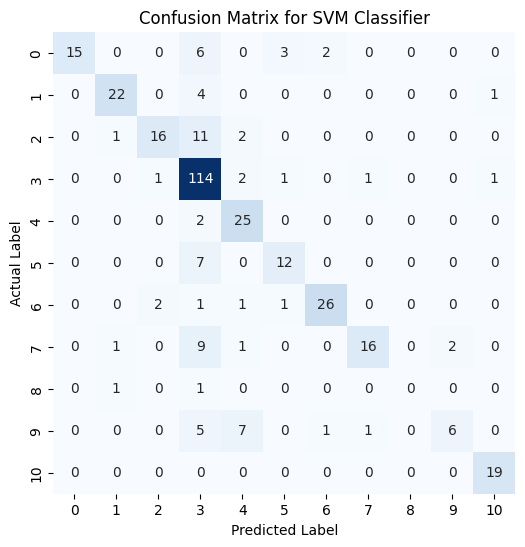

Accuracy:  0.7742857142857142


In [ ]:
#Lets look at the confusion matrix and accuracy for the svm classifier
y_pred = svm_gridSearch.predict(X_val)
plot_confusion_matrix(y_val, y_pred, 'Confusion Matrix for SVM Classifier')
accuracy = accuracy_score(y_val, y_pred)
validation_accuracy.append(accuracy)
print("Accuracy: ", accuracy)

#TODO: Comment what we see from the accuracy and confusion matrix

## MLPClassifier

#TODO: explain why MLP

In [ ]:
#MLP Classifier
mlp = MLPClassifier(random_state=42, activation='relu')
mlp_gridSearch = GridSearchCV(mlp, {'hidden_layer_sizes': [(100,), (100, 100)], 'learning_rate_init': [0.1, 0.01, 0.001], }, scoring='accuracy', n_jobs=-1, verbose=4)
mlp_gridSearch.fit(X_train_resample, y_train_resample)
models.append(mlp_gridSearch)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END hidden_layer_sizes=(100,), learning_rate_init=0.1;, score=0.696 total time=   0.2s
[CV 1/5] END hidden_layer_sizes=(100,), learning_rate_init=0.01;, score=0.674 total time=   0.4s
[CV 4/5] END hidden_layer_sizes=(100,), learning_rate_init=0.1;, score=0.622 total time=   0.4s
[CV 2/5] END hidden_layer_sizes=(100,), learning_rate_init=0.1;, score=0.733 total time=   0.4s
[CV 2/5] END hidden_layer_sizes=(100,), learning_rate_init=0.01;, score=0.667 total time=   0.3s[CV 5/5] END hidden_layer_sizes=(100,), learning_rate_init=0.1;, score=0.756 total time=   0.5s

[CV 3/5] END hidden_layer_sizes=(100,), learning_rate_init=0.1;, score=0.689 total time=   0.6s
[CV 3/5] END hidden_layer_sizes=(100,), learning_rate_init=0.01;, score=0.644 total time=   0.4s
[CV 5/5] END hidden_layer_sizes=(100,), learning_rate_init=0.01;, score=0.756 total time=   0.5s
[CV 4/5] END hidden_layer_sizes=(100,), learning_rate_init=0.01;, score=

/home/maloha/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maloha/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maloha/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END hidden_layer_sizes=(100,), learning_rate_init=0.001;, score=0.717 total time=   1.6s
[CV 2/5] END hidden_layer_sizes=(100,), learning_rate_init=0.001;, score=0.711 total time=   1.6s
[CV 1/5] END hidden_layer_sizes=(100, 100), learning_rate_init=0.01;, score=0.717 total time=   0.2s
[CV 3/5] END hidden_layer_sizes=(100, 100), learning_rate_init=0.1;, score=0.422 total time=   0.5s
[CV 3/5] END hidden_layer_sizes=(100, 100), learning_rate_init=0.01;, score=0.756 total time=   0.4s
[CV 2/5] END hidden_layer_sizes=(100, 100), learning_rate_init=0.01;, score=0.644 total time=   0.2s
[CV 5/5] END hidden_layer_sizes=(100,), learning_rate_init=0.001;, score=0.800 total time=   1.6s


/home/maloha/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END hidden_layer_sizes=(100, 100), learning_rate_init=0.01;, score=0.689 total time=   0.4s
[CV 4/5] END hidden_layer_sizes=(100, 100), learning_rate_init=0.01;, score=0.756 total time=   0.3s
[CV 5/5] END hidden_layer_sizes=(100, 100), learning_rate_init=0.1;, score=0.444 total time=   1.4s


/home/maloha/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END hidden_layer_sizes=(100,), learning_rate_init=0.001;, score=0.756 total time=   1.4s
[CV 1/5] END hidden_layer_sizes=(100, 100), learning_rate_init=0.1;, score=0.239 total time=   0.9s
[CV 1/5] END hidden_layer_sizes=(100, 100), learning_rate_init=0.001;, score=0.761 total time=   1.2s
[CV 3/5] END hidden_layer_sizes=(100, 100), learning_rate_init=0.001;, score=0.667 total time=   1.0s
[CV 2/5] END hidden_layer_sizes=(100, 100), learning_rate_init=0.001;, score=0.689 total time=   1.1s
[CV 4/5] END hidden_layer_sizes=(100, 100), learning_rate_init=0.001;, score=0.756 total time=   0.9s
[CV 5/5] END hidden_layer_sizes=(100, 100), learning_rate_init=0.001;, score=0.711 total time=   0.9s


/home/maloha/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
#Create table with the results of the grid search
results = pd.DataFrame(mlp_gridSearch.cv_results_)
results = results[['param_hidden_layer_sizes', 'param_learning_rate_init', 'mean_test_score']]
results.columns = ['hidden_layer_sizes', 'learning_rate_init', 'mean_test_score']
results = results.sort_values(by='mean_test_score', ascending=False)
results

,hidden_layer_sizes,learning_rate_init,mean_test_score
2,"(100,)",0.001,0.725700
5,"(100, 100)",0.001,0.716618
4,"(100, 100)",0.01,0.712367
1,"(100,)",0.01,0.699227
0,"(100,)",0.1,0.699130
3,"(100, 100)",0.1,0.398937


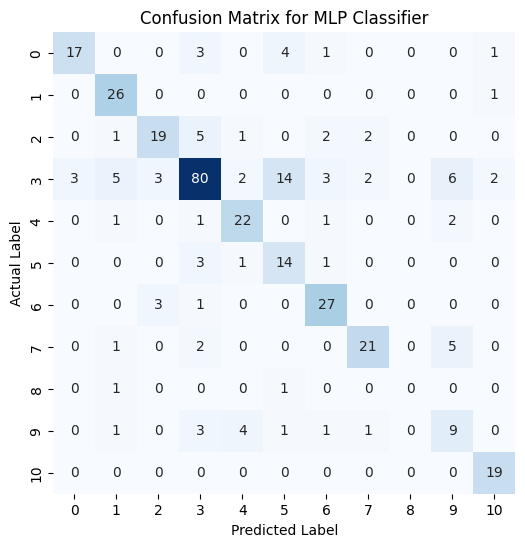

Accuracy:  0.7257142857142858


In [ ]:
#Lets look at the confusion matrix and accuracy for the mlp classifier
y_pred = mlp_gridSearch.predict(X_val)
plot_confusion_matrix(y_val, y_pred, 'Confusion Matrix for MLP Classifier')
accuracy = accuracy_score(y_val, y_pred)
validation_accuracy.append(accuracy)
print("Accuracy: ", accuracy)

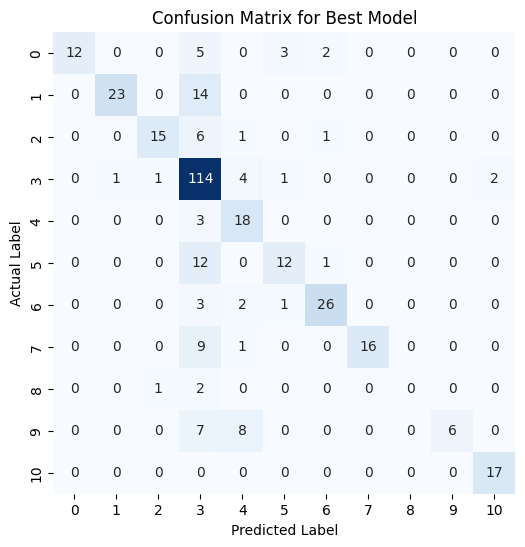

Accuracy:  0.74


In [ ]:
#Find the index of the higest accuracy in validation_accuracy
best_model_index = np.argmax(validation_accuracy)

#Select best model from models
best_model = models[best_model_index]

#Evaluate the best model on the test set
X_test = X_test.reshape(X_test.shape[0], -1)
y_pred = best_model.predict(X_test)

#Plot the confusion matrix for the best model
plot_confusion_matrix(y_test, y_pred, 'Confusion Matrix for Best Model')

#Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Test accuracy: ", accuracy)

#TODO: Comment on what we see

In [ ]:
# train_and_test(rfc, 'Random Forest Classifier with undersampled data', X_train_undersample, y_train_undersample, X_val, y_val)
# train_and_test(svm, 'SVM Classifier with undersampled data', X_train_undersample, y_train_undersample, X_val, y_val)
# train_and_test(mlp, 'MLP Classifier with undersampled data', X_train_undersample, y_train_undersample, X_val, y_val)

In [ ]:
#Plot the confusion matrix and accuracy for the last three models trained
# for i in range(3):
#     plot_confusion_matrix(y_val, trained_and_evaluated_models[-3:][i]['y_pred'], trained_and_evaluated_models[-3:][i]['model_name'])
#     print("Accuracy: ", trained_and_evaluated_models[-3:][i]['accuracy_score'])
#     print()

In [ ]:
#TODO: rewrite the markdown below based on the result

We can see that the accuracy improved a little bit and that our model does not predict 3 as often as previously, but now we make more mistakes when the true label is actually 3. But since the accuracy improved we will move forward with the undersampled training set. Next we will try to use oversampling on the 8's

We can see that a lot of the eights doens't look to good, but we can still train the machine learning models and see if they perform better.

In [ ]:
# train_and_test(rfc, 'Random Forest Classifier with undersampled and oversampled data', X_train_undersample_oversample, y_train_undersample_oversample, X_val, y_val)
# train_and_test(svm, 'SVM Classifier with undersampled and oversampled data', X_train_undersample_oversample, y_train_undersample_oversample, X_val, y_val)
# train_and_test(mlp, 'MLP Classifier with undersampled and oversampled data', X_train_undersample_oversample, y_train_undersample_oversample, X_val, y_val)

In [ ]:
#Plot the confusion matrix and accuracy for the last three models trained
# for i in range(3):
#     plot_confusion_matrix(y_val, trained_and_evaluated_models[-3:][i]['y_pred'], trained_and_evaluated_models[-3:][i]['model_name'])
#     print("Accuracy: ", trained_and_evaluated_models[-3:][i]['accuracy_score'])
#     print()

In [ ]:
#TODO: comment on the results

In [ ]:
#Select the best model based on the accuracy score
# best_model = max(trained_and_evaluated_models, key=lambda x: x['accuracy_score'])

#Print the best model
# print("Best model: ", best_model['model_name'])
# print("Accuracy: ", best_model['accuracy_score'])

#TODO kildereferanse
https://machinelearningmastery.com/tour-of-evaluation-metrics-for-imbalanced-classification/
https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18
https://towardsdatascience.com/8-metrics-to-measure-classification-performance-984d9d7fd7aa